In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from topostats.io import LoadScans
import topostats.filters as topofilters
from topostats.utils import get_mask
from scipy.optimize import least_squares
from scipy.interpolate import splprep, splev
from scipy.spatial import distance
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion
from scipy import ndimage
from scipy.spatial.distance import cdist
from skimage.morphology import label
from skimage.draw import disk

import network_stats as ns

In [3]:
def plot(image: np.ndarray, title=None, zlimit=True, **kwargs) -> None:
    fig, ax = plt.subplots(figsize=(8, 8))
    if zlimit == True:
        vmin=-3
        vmax=4
    else:
        vmin=None
        vmax=None
    ax.imshow(image, vmin=vmin, vmax=vmax, **kwargs)
    if title is not None:
        ax.set_title(title)
    plt.show()

[Sat, 26 Aug 2023 17:06:57] [INFO    ] [topostats] Extracting image from Flat\20221213_KDNA001.0_00020.spm
[Sat, 26 Aug 2023 17:06:57] [INFO    ] [topostats] Loading image from : Flat\20221213_KDNA001.0_00020.spm
[Sat, 26 Aug 2023 17:06:57] [INFO    ] [topostats] [20221213_KDNA001.0_00020] : Loaded image from : Flat\20221213_KDNA001.0_00020.spm
[Sat, 26 Aug 2023 17:06:57] [INFO    ] [topostats] [20221213_KDNA001.0_00020] : Extracted channel Height
[Sat, 26 Aug 2023 17:06:57] [INFO    ] [topostats] [20221213_KDNA001.0_00020] : Pixel to nm scaling : 7.8125


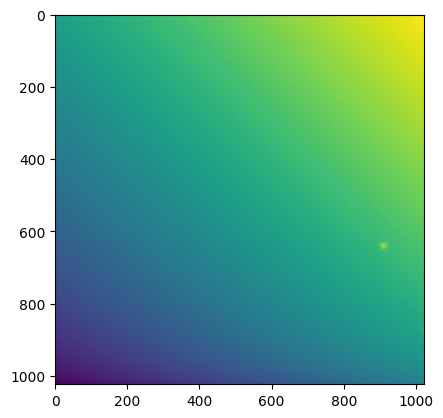

In [4]:
#Flat
FILE_DIR = Path('/Users/sylvi/topo_data/Bradley/Flat/')
#Pristine
file = Path('./Flat/20221213_KDNA001.0_00020.spm')
#file = Path('./flat/20230118_KPN001.0_00005.spm')
#file = Path('./Flat/20230118_KPN001.0_00011.spm')
#file = Path('./Flat/20230126_KPN005.0_00004.spm')
#file = Path(FILE_DIR / '20230118_KPN001.0_00023.spm')
#file = Path('./flat/20230125_KPN005.0_00006.spm')
#file = Path('./flat/20230125_KPN005.0_00028.spm')
# file = Path('./flat/20230126_KPN005.0_00004.spm')
#file = Path('./flat/20230126_KPN005.0_00013.spm')
# file = Path('./flat/20230126_KPN005.0_00019.spm')
# file = Path('./flat/20230126_KPN005.0_00024.spm')
# file = Path('./flat/20230217_KPN010.0_00010.spm')
#file = Path('./flat/20230314_KPN015.0_00016.spm')
#file = Path('./flat/20230417_KPN0018.0_00000.spm')
#file = Path('./flat/20230417_KPN0018.0_00002.spm') 
#EcoPst
#file = Path('./EcoPst/20230406_EPN001_BlackTeflon_Standard.0_00005.spm')
loadscans = LoadScans([file], 'Height')
loadscans.get_data()
p_to_nm = loadscans.pixel_to_nm_scaling
image_raw = loadscans.image
plt.imshow(image_raw)

In [16]:
#Parameters
Rosette_Thres = 1.25
Gauss_Min_Size = 10
Gauss_Max_Size = 5000 
Gauss_Sigma = 15
Gauss_Thres = 0.003
Fibril_Min_Size = 15
Fibril_Max_Size = 300
Threshold_Dist = 0.4 


In [17]:
filters = topofilters.Filters(
    image = image_raw,
    filename = file,
    pixel_to_nm_scaling = p_to_nm,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 1.0, 'lower': None},
    gaussian_size=1.0,
    remove_scars={'run': False}
)

filters.filter_image()

[Sat, 26 Aug 2023 17:08:17] [INFO    ] [topostats] [Flat\20221213_KDNA001.0_00020.spm] : Median flattening without mask


[Sat, 26 Aug 2023 17:08:17] [INFO    ] [topostats] [Flat\20221213_KDNA001.0_00020.spm] : Plane tilt removal without mask
[Sat, 26 Aug 2023 17:08:17] [INFO    ] [topostats] [Flat\20221213_KDNA001.0_00020.spm] : x-polyfit 1st order: [  0.09547678 -48.79440781]
[Sat, 26 Aug 2023 17:08:17] [INFO    ] [topostats] [Flat\20221213_KDNA001.0_00020.spm] : y-polyfit 1st order: [ 1.86929762e-18 -1.62227955e-15]
[Sat, 26 Aug 2023 17:08:17] [INFO    ] [topostats] [Flat\20221213_KDNA001.0_00020.spm] : Removing x plane tilt
[Sat, 26 Aug 2023 17:08:18] [INFO    ] [topostats] [Flat\20221213_KDNA001.0_00020.spm] : removing y plane tilt
[Sat, 26 Aug 2023 17:08:19] [INFO    ] [topostats] [Flat\20221213_KDNA001.0_00020.spm] : Remove quadratic bow without mask
[Sat, 26 Aug 2023 17:08:19] [INFO    ] [topostats] [Flat\20221213_KDNA001.0_00020.spm] : x polyfit 2nd order: [ 7.86995599e-07 -8.05096498e-04 -4.86572730e+01]
[Sat, 26 Aug 2023 17:08:20] [INFO    ] [topostats] [Flat\20221213_KDNA001.0_00020.spm] : Ski

[Sat, 26 Aug 2023 17:08:25] [INFO    ] [topostats] [Flat\20221213_KDNA001.0_00020.spm] : Median flattening without mask


[Sat, 26 Aug 2023 17:08:26] [INFO    ] [topostats] [Flat\20221213_KDNA001.0_00020.spm] : Plane tilt removal without mask
[Sat, 26 Aug 2023 17:08:27] [INFO    ] [topostats] [Flat\20221213_KDNA001.0_00020.spm] : x-polyfit 1st order: [  0.09547678 -48.79440781]
[Sat, 26 Aug 2023 17:08:27] [INFO    ] [topostats] [Flat\20221213_KDNA001.0_00020.spm] : y-polyfit 1st order: [ 1.86929762e-18 -1.62227955e-15]
[Sat, 26 Aug 2023 17:08:27] [INFO    ] [topostats] [Flat\20221213_KDNA001.0_00020.spm] : Removing x plane tilt
[Sat, 26 Aug 2023 17:08:28] [INFO    ] [topostats] [Flat\20221213_KDNA001.0_00020.spm] : removing y plane tilt
[Sat, 26 Aug 2023 17:08:30] [INFO    ] [topostats] [Flat\20221213_KDNA001.0_00020.spm] : Remove quadratic bow without mask
[Sat, 26 Aug 2023 17:08:30] [INFO    ] [topostats] [Flat\20221213_KDNA001.0_00020.spm] : x polyfit 2nd order: [ 7.86995599e-07 -8.05096498e-04 -4.86572730e+01]
[Sat, 26 Aug 2023 17:08:32] [INFO    ] [topostats] [Flat\20221213_KDNA001.0_00020.spm] : Ski

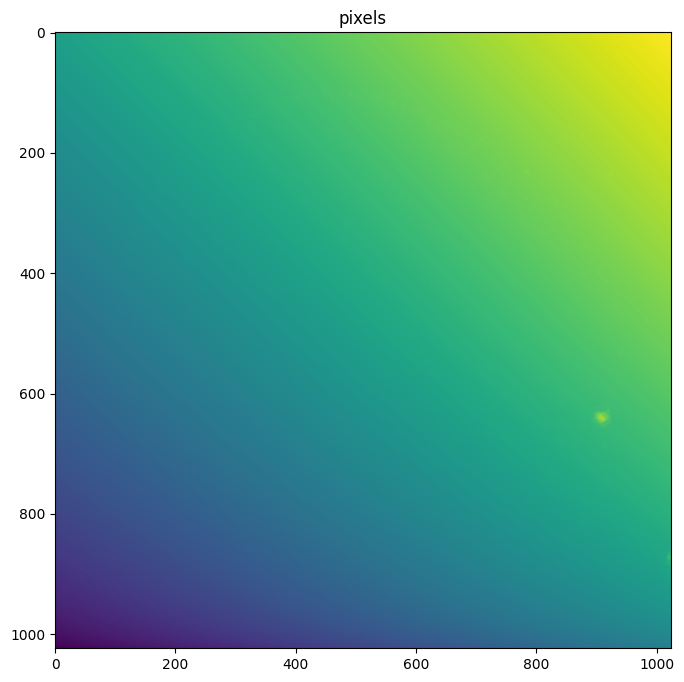

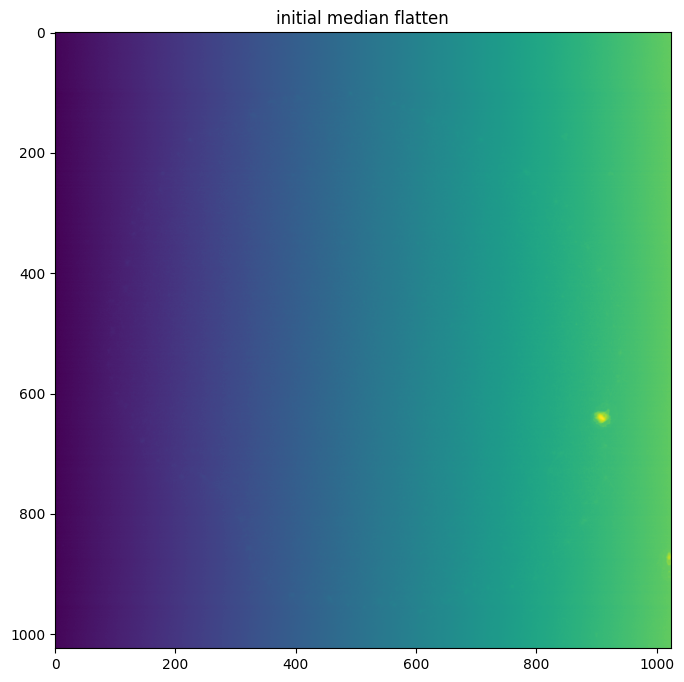

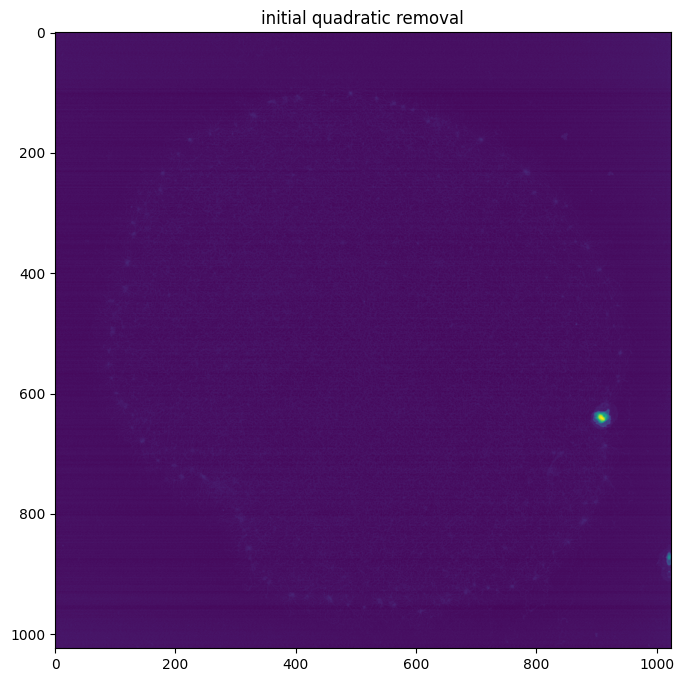

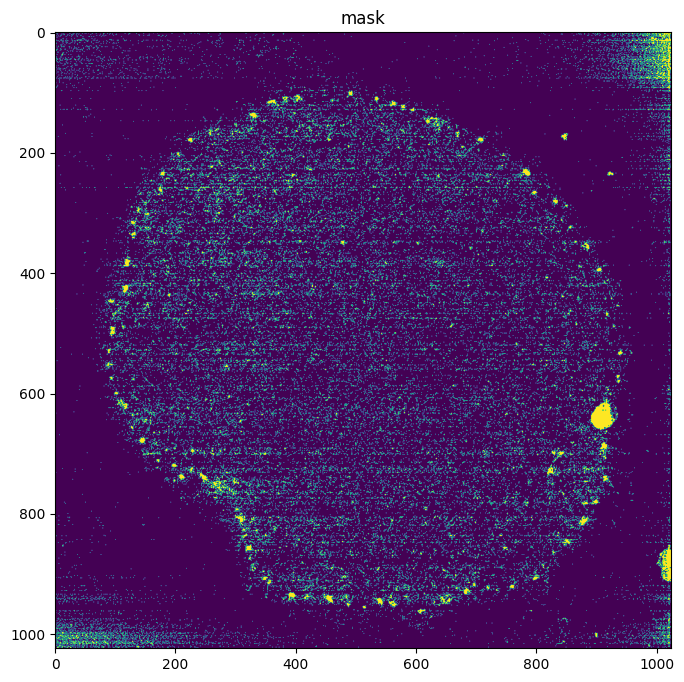

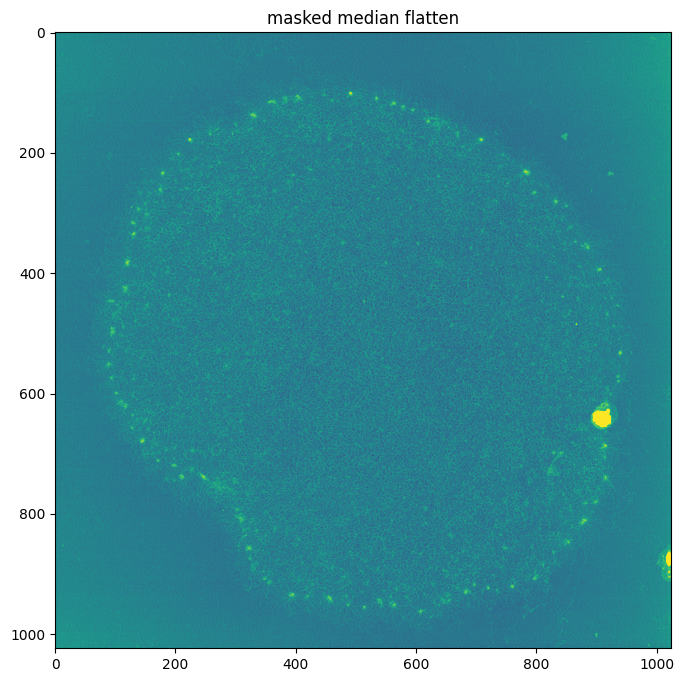

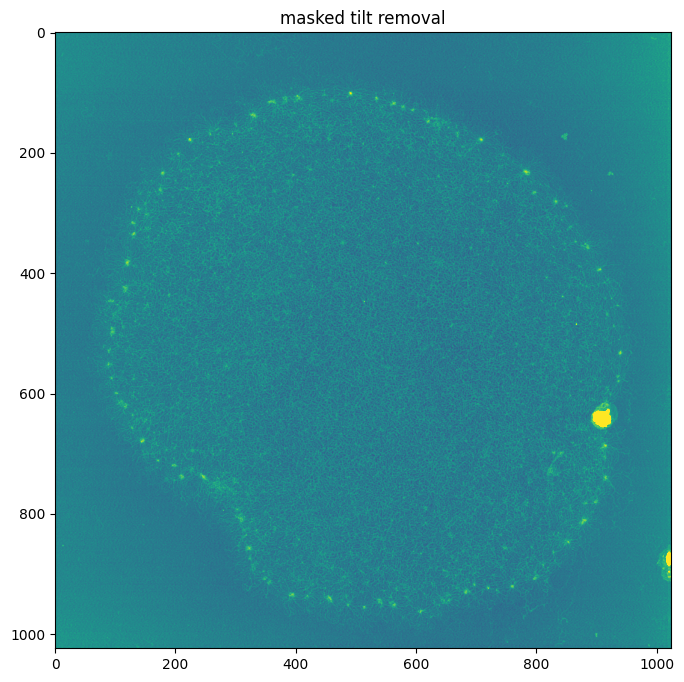

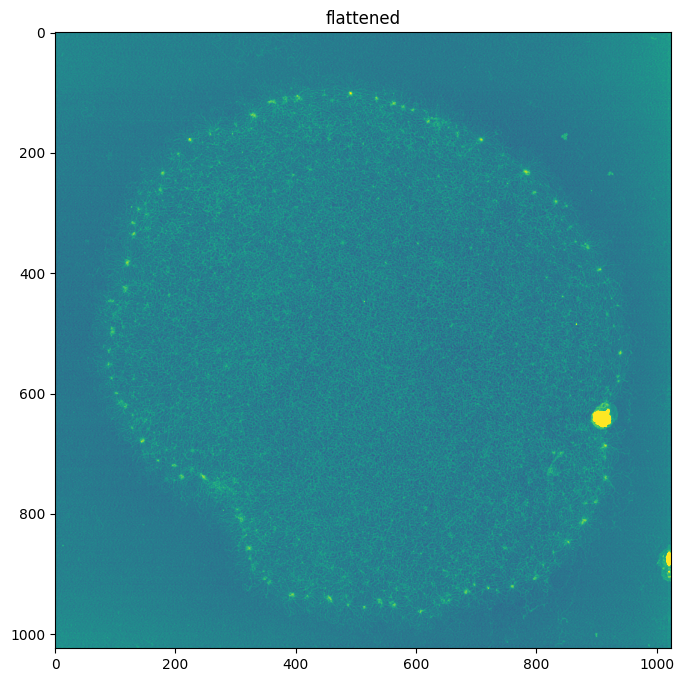

In [18]:
# Flatten the image
filters = topofilters.Filters(
    image = image_raw,
    filename = file,
    pixel_to_nm_scaling = p_to_nm,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 1.0, 'lower': None},
    gaussian_size=1.0,
    remove_scars={'run': False}
)

filters.filter_image()

# Plot the flattened image
plot(filters.images['pixels'], title='pixels', zlimit=False)
plot(filters.images['initial_median_flatten'], zlimit=False, title='initial median flatten')
plot(filters.images['initial_quadratic_removal'], zlimit=False, title='initial quadratic removal')
plot(filters.images['mask'], title='mask', zlimit=False)
plot(filters.images['masked_median_flatten'], title='masked median flatten')
plot(filters.images['masked_tilt_removal'], title='masked tilt removal')

if np.array_equal(filters.images['masked_tilt_removal'], filters.images['masked_median_flatten']):
    print("EQUAL")

flattened = filters.images['zero_average_background']
plot(flattened, title='flattened')

thresholds: defaultdict(None, {'upper': 0.9244314799477588})
[Sat, 26 Aug 2023 17:08:47] [INFO    ] [topostats] [None] : Masking (upper) Threshold: 0.9244314799477588


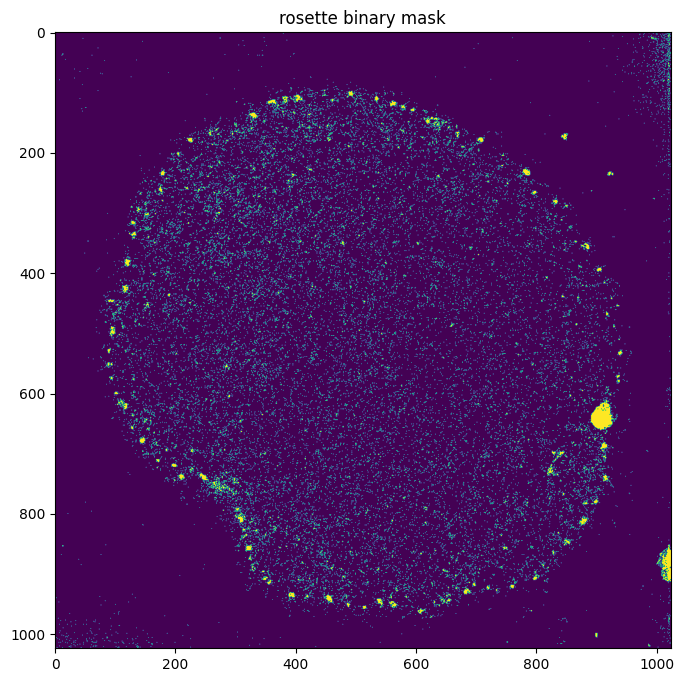

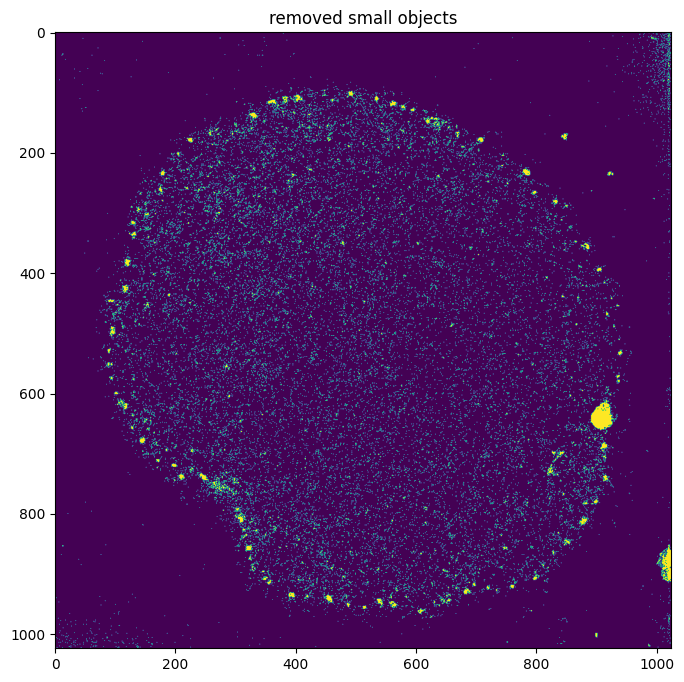

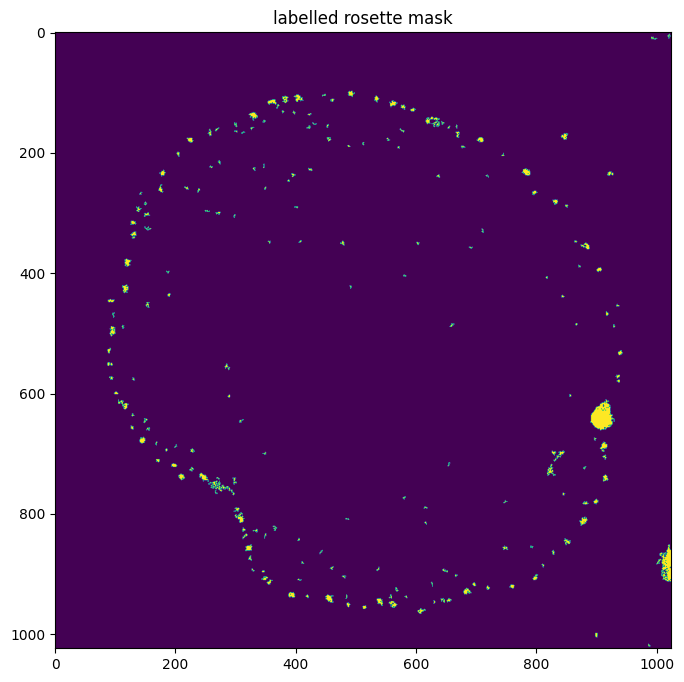

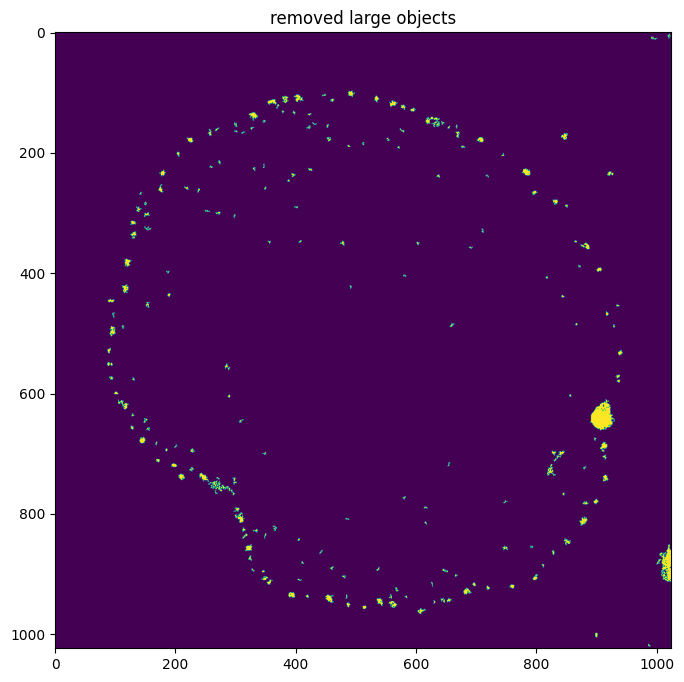

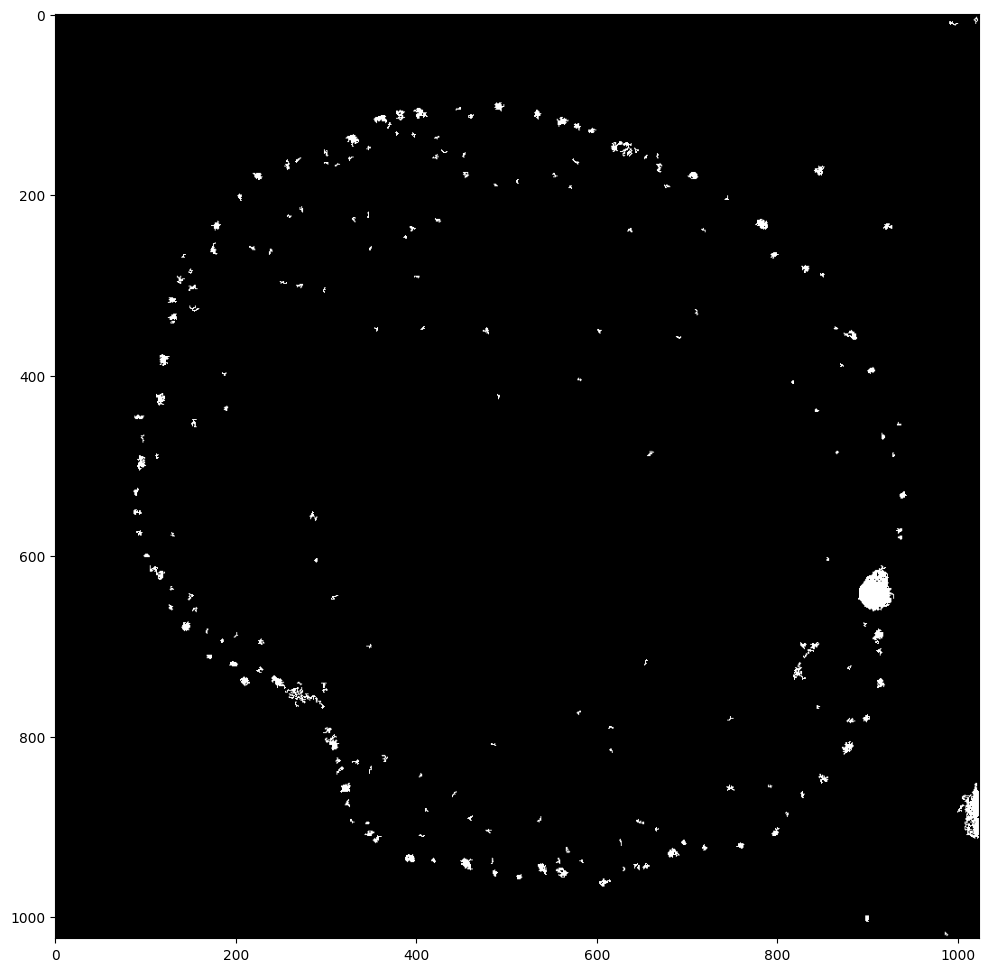

In [19]:
# Thresholding

from skimage.morphology import remove_small_objects, label
from skimage.measure import regionprops

rosette_thresholds = topofilters.get_thresholds(
    flattened,
    threshold_method='std_dev',
    threshold_std_dev={'upper': Rosette_Thres, 'lower': None}
)

print(f'thresholds: {rosette_thresholds}')
rosette_mask = topofilters.get_mask(image=flattened, thresholds=rosette_thresholds)
plot(rosette_mask.astype(bool), title='rosette binary mask', zlimit=False)

# Remove small objects
removed_small_objects = remove_small_objects(rosette_mask, Gauss_Min_Size)
plot(rosette_mask.astype(bool), title='removed small objects', zlimit=False)
# Remove large objects
labelled_rosette_mask = label(removed_small_objects)
plot(labelled_rosette_mask.astype(bool), title='labelled rosette mask', zlimit=False)
regions = regionprops(labelled_rosette_mask)
for props_index, props in enumerate(regions):
    if props.area > Gauss_Max_Size:
        labelled_rosette_mask[labelled_rosette_mask==props.label] = 0

plot(labelled_rosette_mask.astype(bool), title='removed large objects', zlimit=False)
plt.show()

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(labelled_rosette_mask.astype(bool), cmap='gray')


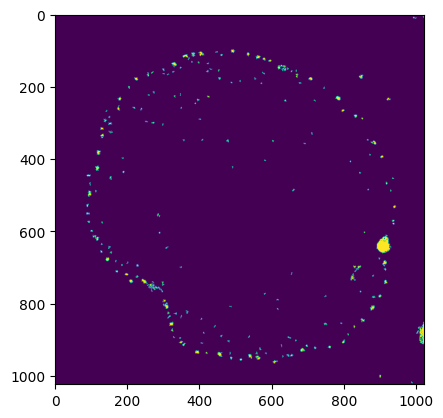

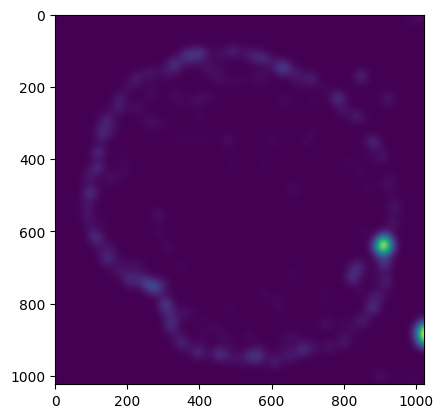

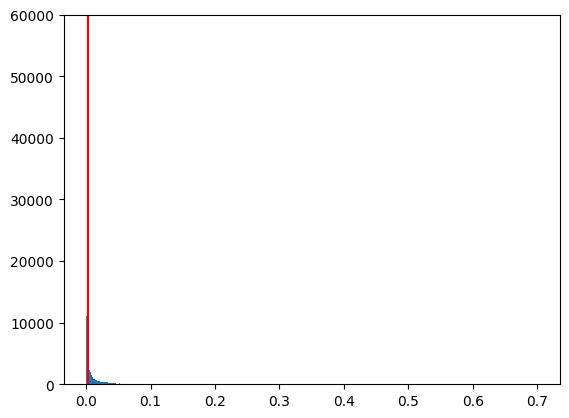

otsu threshold: 0.003


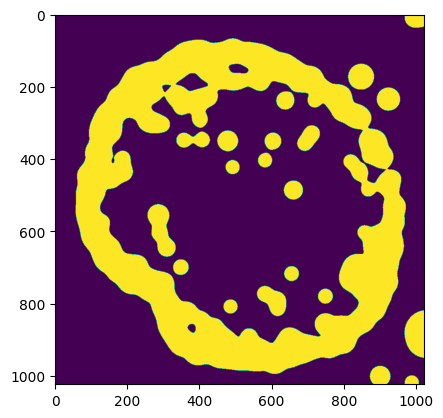

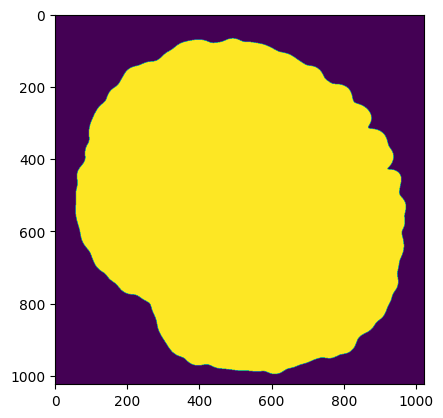

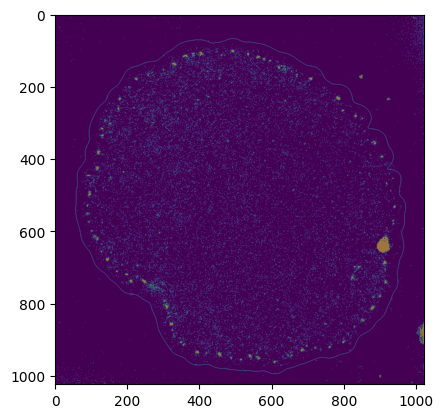

In [20]:
# Get the edge of the structure

plt.imshow(labelled_rosette_mask.astype(bool))
plt.show()
gauss = gaussian(labelled_rosette_mask.astype(bool), Gauss_Sigma)
plt.imshow(gauss)
plt.show()

# threshold = threshold_otsu(gauss)
threshold = Gauss_Thres

fig, ax = plt.subplots()
ax.hist(gauss.flatten(), bins='auto')
ax.set_ylim(0, 60000)
plt.axvline(x=threshold, color='r')
plt.show()

print(f'otsu threshold: {threshold}')
thresholded = gauss > threshold
plt.imshow(thresholded)
plt.show()

labelled = label(thresholded)
region_props = regionprops(labelled)
max_size = max([props.area for props in region_props])
thresholded = remove_small_objects(thresholded, min_size=max_size-1)
thresholded = ndimage.binary_fill_holes(thresholded)
plt.imshow(thresholded)
plt.show()

# Add padding (needed for erosion)
padded = np.pad(thresholded, 1)
# Erode by 1 pixel
eroded = binary_erosion(padded)
# Remove padding
eroded = eroded[1:-1, 1:-1]

# Edges is equal to the difference between the
# original image and the eroded image.
edges = thresholded.astype(int) - eroded.astype(int)
plt.imshow(rosette_mask)
plt.imshow(edges, alpha=0.5)
plt.show()

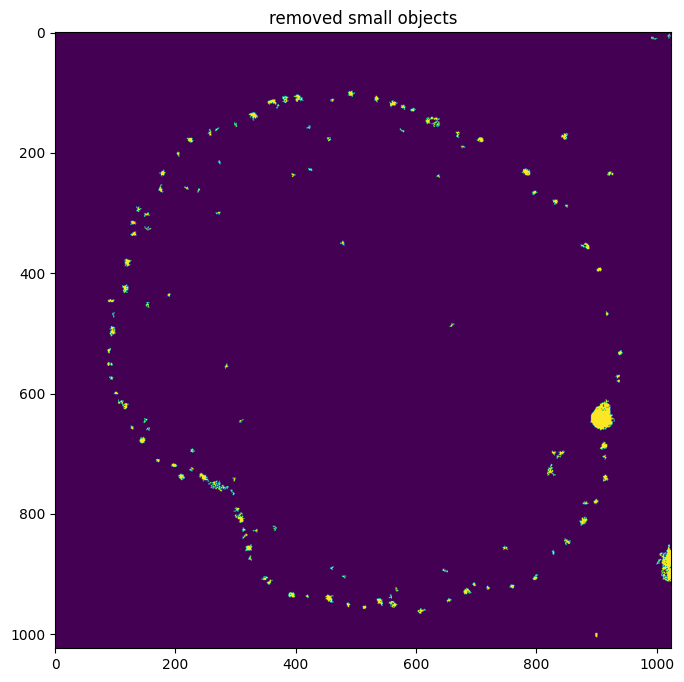

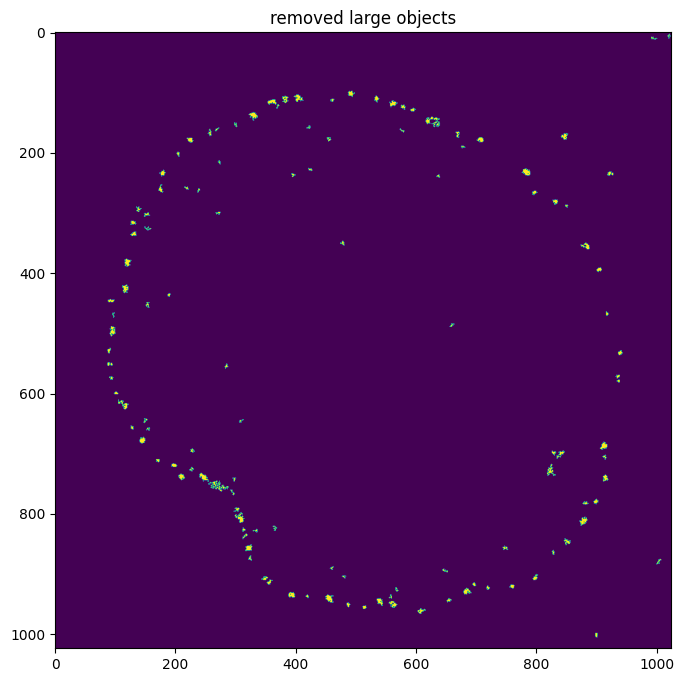

In [21]:
#Second Thresholding
fibril_thres = rosette_mask.copy()
# Remove small objects
fib_removed_small_objects = remove_small_objects(fibril_thres, Fibril_Min_Size)
plot(fib_removed_small_objects.astype(bool), title='removed small objects', zlimit=False)
#Remove large objects
fibril_rosette_mask = label(fib_removed_small_objects)
#plot(fibril_rosette_mask.astype(bool), title='fibril rosette mask', zlimit=False)
regions = regionprops(fibril_rosette_mask)
for props_index, props in enumerate(regions):
    if props.area > Fibril_Max_Size:
        fibril_rosette_mask[fibril_rosette_mask==props.label] = 0

plot(fibril_rosette_mask.astype(bool), title='removed large objects', zlimit=False)
plt.show()


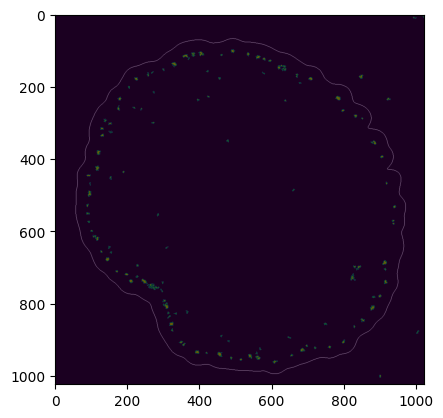

mean distance: 59.99710478377635
std dev distance: 50.97846296836629


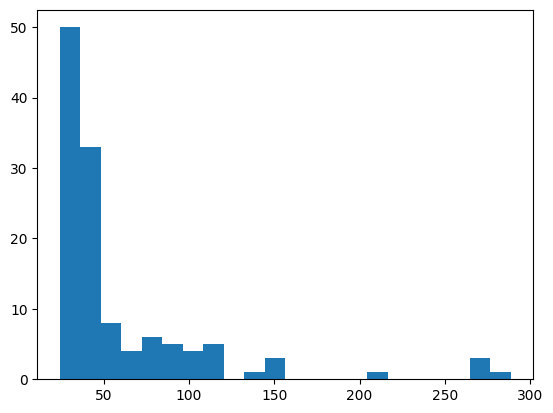

distance threshold: 39.605719596429836
points shape: (71, 2)


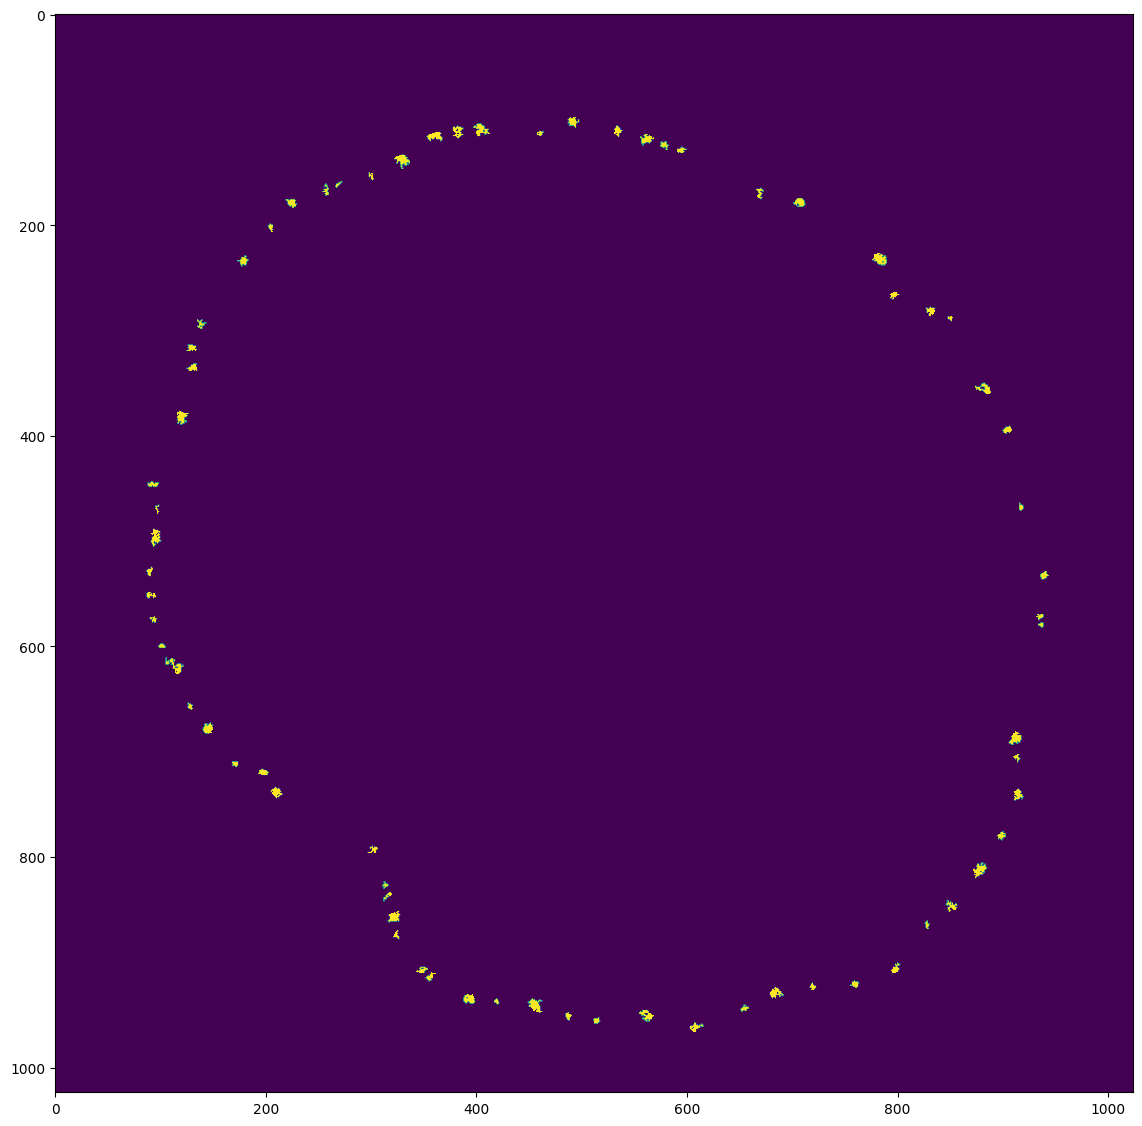

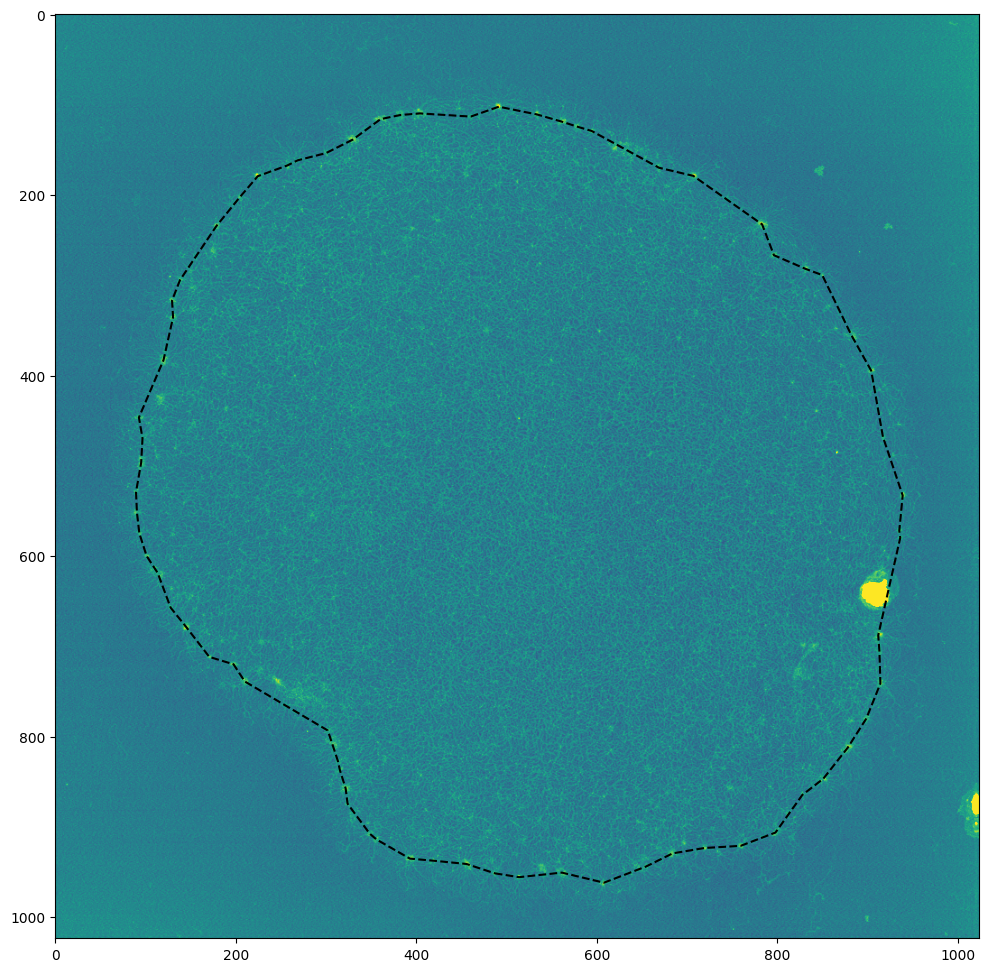

In [22]:
plt.imshow(fibril_rosette_mask.astype(bool))
plt.imshow(edges, alpha=0.6, cmap='gray')
plt.show()

edge_positions = np.transpose(np.nonzero(edges))
region_props = regionprops(fibril_rosette_mask)
min_distances = np.zeros(len(region_props))
for props_index, props in enumerate(region_props):
    proplabel = props['label']
    centroid = np.array(props['centroid']).reshape(-1, 2)
    distances = np.linalg.norm(centroid - edge_positions, axis=1)
    min_distance = np.min(distances)
    min_distances[props_index] = min_distance

print(f'mean distance: {np.mean(min_distances)}')
print(f'std dev distance: {np.std(min_distances)}')
plt.hist(min_distances, bins='auto')
plt.show()
distance_threshold = np.mean(min_distances) - Threshold_Dist * np.std(min_distances)
print(f'distance threshold: {distance_threshold}')

removed_too_far_points = fibril_rosette_mask.copy()
points = np.array([])
for props_index, props in enumerate(region_props):
    proplabel = props['label']
    centroid = np.array(props['centroid']).reshape(-1, 2)
    distances = np.linalg.norm(centroid - edge_positions, axis=1)
    min_distance = np.min(distances)
    if min_distance > distance_threshold:
        removed_too_far_points[removed_too_far_points == proplabel] = 0
    else:
        points = np.append(points, centroid).reshape(-1, 2)

points = np.array(points)
print(f'points shape: {points.shape}')

fig, ax = plt.subplots(figsize=(14, 14))
ax.imshow(removed_too_far_points.astype(bool))
plt.show()

# Find centroids of remaining points
labelled = label(removed_too_far_points)
regions = regionprops(labelled)
points = np.ndarray((len(regions), 2))
for props_index, props in enumerate(regions):
    points[props_index, :] = props.centroid

centroid = np.array([np.mean(points[:, 0]), np.mean(points[:, 1])])

# Function to find angle of point from centroid
def angle(point, centroid):
    dx, dy = point - centroid
    return (np.arctan2(dy, dx) + 2 * np.pi) % (2 * np.pi)

# Sort the points based on their angles around the centroid
sorted = points[np.argsort([angle(point, centroid) for point in points])]

xs = np.append(sorted[:, 1], sorted[0, 1])
ys = np.append(sorted[:, 0], sorted[0, 0])

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(flattened, vmin=-3, vmax=4)
ax.plot(xs, ys, 'k--')

plt.show()


In [23]:
sorted_loop = np.append(sorted, sorted[0, :]).reshape(-1, 2)
global_density, internal_density, near_outline_density, dens_internal, dist_internal, dens_noutline, dist_noutline = ns.network_density_internal(
    nodes=sorted_loop,
    image=flattened,
    px_to_nm=p_to_nm,
    stepsize_px=50,
    kernel_size=50,
    gaussian_sigma=10
)


density map dimensions: (20, 20)


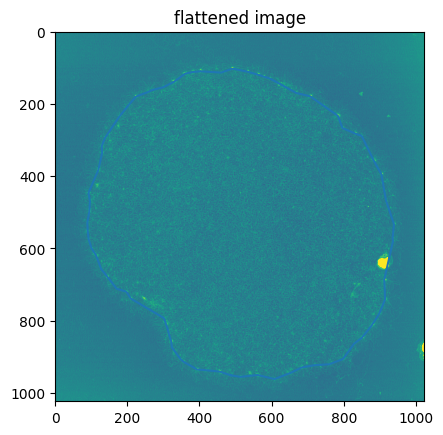

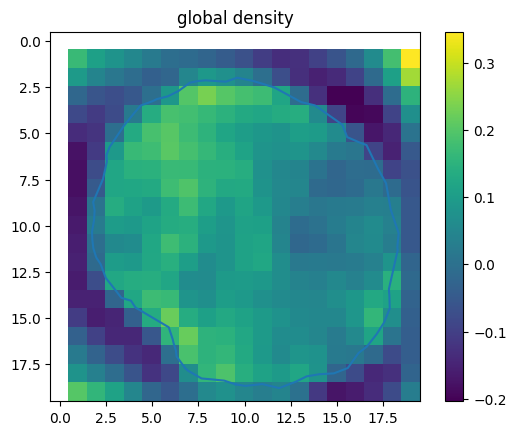

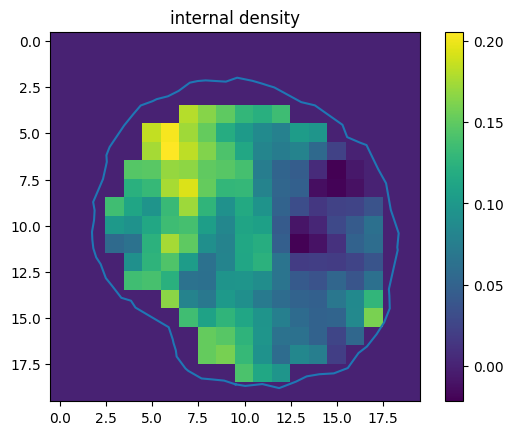

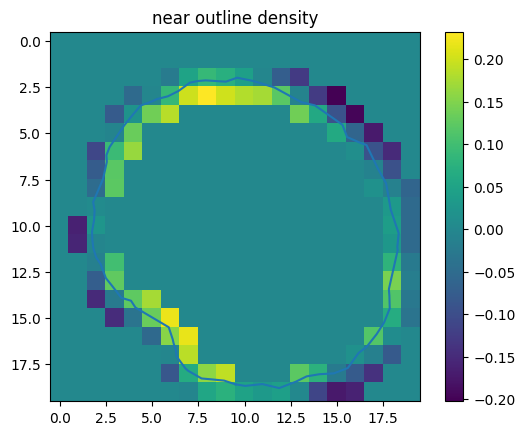

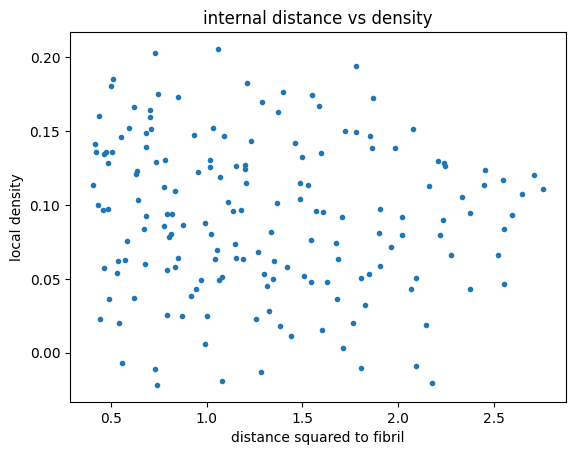

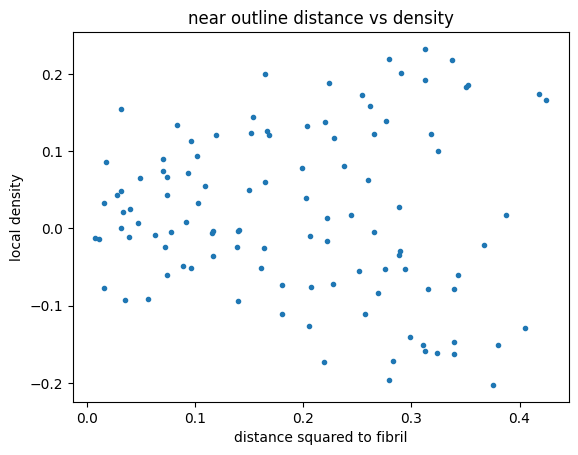

In [24]:
#Apply unit scaling
dist_internal = np.sqrt(dist_internal)*p_to_nm*0.001
dist_noutline = np.sqrt(dist_noutline)*p_to_nm*0.001

scaling_factor = flattened.shape[0] / internal_density.shape[0]
plt.imshow(flattened, vmin=-3, vmax=4)
plt.plot(sorted_loop[:, 1], sorted_loop[:, 0])
plt.title('flattened image')
plt.show()
plt.imshow(global_density)
plt.plot(sorted_loop[:, 1] / scaling_factor, sorted_loop[:, 0] / scaling_factor)
plt.colorbar()
plt.title('global density')
plt.show()
plt.imshow(internal_density)
plt.plot(sorted_loop[:, 1] / scaling_factor, sorted_loop[:, 0] / scaling_factor)
plt.colorbar()
plt.title('internal density')
plt.show()
plt.imshow(near_outline_density)
plt.plot(sorted_loop[:, 1] / scaling_factor, sorted_loop[:, 0] / scaling_factor)
plt.colorbar()
plt.title('near outline density')
plt.show()


plt.scatter(x=dist_internal, y=dens_internal, marker='.')
plt.xlabel('distance squared to fibril')
plt.ylabel('local density')
plt.title('internal distance vs density')
plt.show()
plt.scatter(x=dist_noutline, y=dens_noutline, marker='.')
plt.title('near outline distance vs density')
plt.xlabel('distance squared to fibril')
plt.ylabel('local density')
plt.show()

Image: Flat\20221213_KDNA001.0_00020.spm
- molecule stats -
area: 33.74 μm^2
perimeter: 21.33 μm
min_feret: 6.15 μm | max_feret: 7.24 μm
- curvature stats -
min curvature: 5.322671373310181e-06, max curvature: 0.06261025108460581, mean curvature: 0.009529060080254505 sum curvature: 20.296897970942094


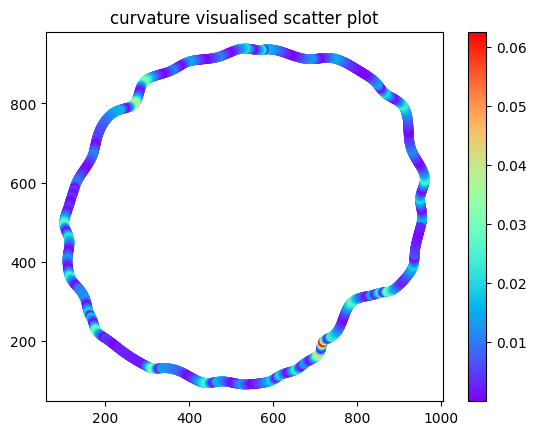

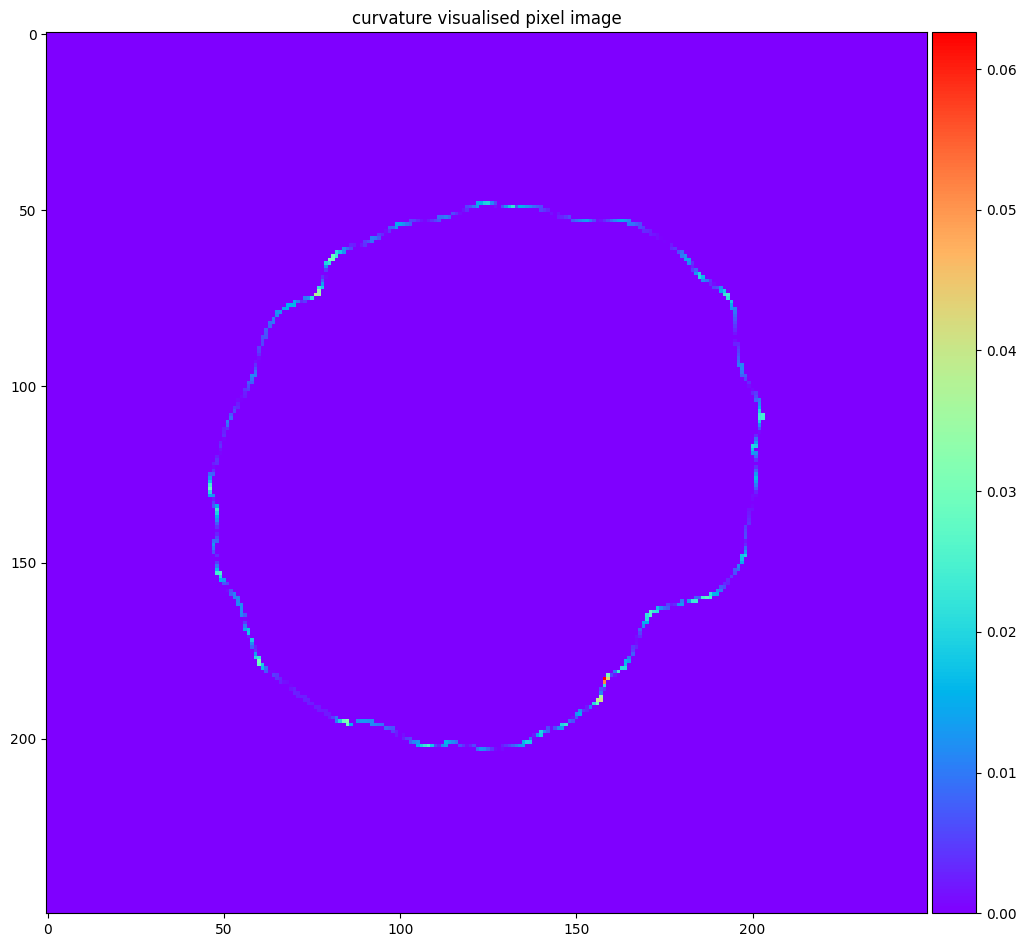

- node stats -
number of nodes in perimeter: 71
node areas | min: 915.53 nm^2 max: 6408.69 nm^2 mean: 2868.65 nm^2
node volumes | min: 1114.63 nm^3 max: 11958.08 nm^3 mean: 4630.36 nm^3
mean node height values | min: 1.22 nm max: 2.05 nm mean: 1.57 nm
max node height values | min: 1.70 nm max: 5.12 nm mean: 2.72 nm

Full Curvature Values:
[0.0037548  0.00153145 0.00286219 ... 0.0011924  0.00080075 0.00292109] 

---------------------------------------------------------------


In [28]:

MICRON_SCALING_FACTOR = 0.001
P_TO_MICRON = p_to_nm * MICRON_SCALING_FACTOR

print('Image:',file)

print('- molecule stats -')
area = ns.network_area(sorted) * P_TO_MICRON**2
print(f'area: {area:.2f} μm^2')
perimeter = ns.polygon_perimeter(sorted) * P_TO_MICRON
print(f'perimeter: {perimeter:.2f} μm')
min_feret, max_feret = ns.network_feret_diameters(sorted)
print(f'min_feret: {min_feret* P_TO_MICRON:.2f} μm | max_feret: {max_feret* P_TO_MICRON:.2f} μm')
regionstats = ns.node_stats(labelled_image=labelled, image=flattened)

interpolated_curvatures, interpolated_points = ns.interpolate_spline_and_get_curvature(points=sorted, interpolation_number=30)
print('- curvature stats -')
print(f'min curvature: {np.min(interpolated_curvatures)}, max curvature: {np.max(interpolated_curvatures)}, mean curvature: {np.mean(interpolated_curvatures)} sum curvature: {np.sum(interpolated_curvatures)}')

ns.visualise_curvature_scatter(curvatures=interpolated_curvatures, points=interpolated_points, title="curvature visualised scatter plot")
ns.visualise_curvature_pixel_image(curvatures=interpolated_curvatures, points=interpolated_points, title="curvature visualised pixel image", image_size=250, figsize=(12, 12))

print('- node stats -')
num_perimeter_nodes = sorted.shape[0]
print(f'number of nodes in perimeter: {num_perimeter_nodes}')
print(f'node areas | min: {np.min(regionstats["node areas"]* p_to_nm**2):.2f} nm^2 max: {np.max(regionstats["node areas"]* p_to_nm**2):.2f} nm^2 mean: {np.mean(regionstats["node areas"]* p_to_nm**2):.2f} nm^2')
print(f'node volumes | min: {np.min(regionstats["node volumes"]* p_to_nm**2):.2f} nm^3 max: {np.max(regionstats["node volumes"]* p_to_nm**2):.2f} nm^3 mean: {np.mean(regionstats["node volumes"]* p_to_nm**2):.2f} nm^3')
print(f'mean node height values | min: {np.min(regionstats["node mean_heights"]):.2f} nm max: {np.max(regionstats["node mean_heights"]):.2f} nm mean: {np.mean(regionstats["node mean_heights"]):.2f} nm')
print(f'max node height values | min: {np.min(regionstats["node max_heights"]):.2f} nm max: {np.max(regionstats["node max_heights"]):.2f} nm mean: {np.mean(regionstats["node max_heights"]):.2f} nm\n')

print('Full Curvature Values:')
print(interpolated_curvatures,"\n")
print("---------------------------------------------------------------")

In [ ]:
"""data = [dist_internal,dens_internal,dist_noutline,dens_noutline]

with open('density.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    for stat in data: 
        writer.writerow(np.transpose(stat))
"""

"data = [dist_internal,dens_internal,dist_noutline,dens_noutline]\n\nwith open('density.csv', 'w', encoding='UTF8') as f:\n    writer = csv.writer(f)\n    writer.writerow(header)\n    for stat in data: \n        writer.writerow(np.transpose(stat))\n"

In [ ]:

MICRON_SCALING_FACTOR = 0.001
P_TO_MICRON = p_to_nm * MICRON_SCALING_FACTOR

print('Image:',file)

print('- molecule stats -')
area = ns.network_area(sorted)* P_TO_MICRON**2
print(f'area: {area:.2f} μm^2')
perimeter = ns.polygon_perimeter(sorted)* P_TO_MICRON
print(f'perimeter: {perimeter:.2f} μm')
min_feret, max_feret = ns.network_feret_diameters(sorted)
print(f'min_feret: {min_feret* P_TO_MICRON:.2f} μm | max_feret: {max_feret* P_TO_MICRON:.2f} μm')
regionstats = ns.node_stats(labelled_image=labelled, image=flattened)
interp_curvatures, interpolated_points = ns.interpolate_spline_and_get_curvature(points,5000)
print(f'mean_curvature: {np.mean(interp_curvatures)}')

print('- node stats -')
num_perimeter_nodes = sorted.shape[0]
print(f'number of nodes in perimeter: {num_perimeter_nodes}')
print(f'node areas | min: {np.min(regionstats["node areas"]* p_to_nm**2):.2f} nm^2 max: {np.max(regionstats["node areas"]* p_to_nm**2):.2f} nm^2 mean: {np.mean(regionstats["node areas"]* p_to_nm**2):.2f} nm^2')
print(f'node volumes | min: {np.min(regionstats["node volumes"]* p_to_nm**2):.2f} nm^3 max: {np.max(regionstats["node volumes"]* p_to_nm**2):.2f} nm^3 mean: {np.mean(regionstats["node volumes"]* p_to_nm**2):.2f} nm^3')
print(f'mean node height values | min: {np.min(regionstats["node mean_heights"]):.2f} nm max: {np.max(regionstats["node mean_heights"]):.2f} nm mean: {np.mean(regionstats["node mean_heights"]):.2f} nm')
print(f'max node height values | min: {np.min(regionstats["node max_heights"]):.2f} nm max: {np.max(regionstats["node max_heights"]):.2f} nm mean: {np.mean(regionstats["node max_heights"]):.2f} nm\n')

print('Full Curvature Values:')
print(interp_curvatures,"\n")
print("---------------------------------------------------------------")

Image: flat\20230118_KPN001.0_00023.spm
- molecule stats -
area: 39.05 μm^2
perimeter: 23.39 μm
min_feret: 6.48 μm | max_feret: 7.71 μm
mean_curvature: 0.15527140177876542
sum_curvature: 558977.0464035555
- node stats -
number of nodes in perimeter: 72
node areas | min: 686.65 nm^2 max: 5767.82 nm^2 mean: 1617.43 nm^2
node volumes | min: 1430.71 nm^3 max: 14592.56 nm^3 mean: 4243.98 nm^3
mean node height values | min: 2.08 nm max: 3.54 nm mean: 2.55 nm
max node height values | min: 2.31 nm max: 5.89 nm mean: 3.34 nm

Full Curvature Values:
[0.02356438 0.00736178 0.01177599 ... 0.01178552 0.00736564 0.02356913] 

---------------------------------------------------------------
